In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightgbm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Loading the training data and preprocessing which should be changed for Turvo Data

In [10]:
bookings_df_train = pd.read_csv("train.csv", delim_whitespace= True)
#print(bookings_df_train.head())

actions_df_train = pd.read_csv("Test.csv", delim_whitespace= True)
#print(actions_df_train.head())


whole_df = pd.merge(bookings_df_train,actions_df_train,
                        on = ['ymd','user_id','session_id'], how = "inner")

del whole_df['ymd'];del whole_df['user_id'];del whole_df['session_id']
for each_column in whole_df.columns:
    whole_df[each_column] = whole_df[each_column].astype('category')

    
cols = list(whole_df)
cols.append(cols.pop(cols.index('has_booking')))
#print (cols)

whole_df = whole_df.ix[:, cols]
#whole_df.head()

/Users/vigneshsureshbabu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Checking For Missing Values

In [4]:
#CHECK FOR MISSING VALUES
for col in whole_df.columns:
    print (col,end=": ")
    print (sum(whole_df[col].isnull()))

referer_code: 0
is_app: 0
agent_id: 0
traffic_type: 0
action_id: 0
reference: 0
step: 0
has_booking: 0


## Splitting the train and test data

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(whole_df, test_size = 0.2)
X_train, y_train = train.drop('has_booking', axis=1), train['has_booking']
X_test, y_test = test.drop('has_booking', axis=1), test['has_booking']

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(4690290, 7)
(4690290,)
(1172573, 7)
(1172573,)


## Train the Model Using Gradient Boosting

## Model can be converted to Random Forest by changing 'boosting' to 'rf'

In [19]:
cols = list(whole_df.columns)
print (cols)

cols.remove('has_booking')

print (cols)

train_data = lightgbm.Dataset(X_train, label=y_train, categorical_feature=cols)
test_data = lightgbm.Dataset(X_test, label=y_test)


parameters = {
    'objective': 'regression',
    'metric': {'l2', 'mse'},
    'boosting': 'gbdt',
    'num_leaves': 31,
    'bagging_fraction': 0.75,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 3
}


model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=25,
                       early_stopping_rounds=10)


['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step', 'has_booking']
['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']


/Users/vigneshsureshbabu/anaconda/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/vigneshsureshbabu/anaconda/lib/python3.5/site-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['action_id', 'agent_id', 'is_app', 'reference', 'referer_code', 'step', 'traffic_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/vigneshsureshbabu/anaconda/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's l2: 0.112298	valid_0's l2: 0.112298
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.111481	valid_0's l2: 0.111481
[3]	valid_0's l2: 0.110741	valid_0's l2: 0.110741
[4]	valid_0's l2: 0.110073	valid_0's l2: 0.110073
[5]	valid_0's l2: 0.109435	valid_0's l2: 0.109435
[6]	valid_0's l2: 0.108877	valid_0's l2: 0.108877
[7]	valid_0's l2: 0.108342	valid_0's l2: 0.108342
[8]	valid_0's l2: 0.107862	valid_0's l2: 0.107862
[9]	valid_0's l2: 0.107413	valid_0's l2: 0.107413
[10]	valid_0's l2: 0.106995	valid_0's l2: 0.106995
[11]	valid_0's l2: 0.106579	valid_0's l2: 0.106579
[12]	valid_0's l2: 0.106229	valid_0's l2: 0.106229
[13]	valid_0's l2: 0.105857	valid_0's l2: 0.105857
[14]	valid_0's l2: 0.105538	valid_0's l2: 0.105538
[15]	valid_0's l2: 0.105227	valid_0's l2: 0.105227
[16]	valid_0's l2: 0.104914	valid_0's l2: 0.104914
[17]	valid_0's l2: 0.104644	valid_0's l2: 0.104644
[18]	valid_0's l2: 0.104373	valid_0's l2: 0.104373
[19]	valid_0's l2: 0.104144	v

## Predicting on the test data using the trained model

In [8]:
predict_y_proba_gbm = model.predict(X_test, num_iteration=model.best_iteration)
predict_y_gbm = np.where(predict_y_proba_gbm.reshape((predict_y_proba_gbm.shape[0])) > 0.5, 1, 0)

#y = model.predict(X_test)

df_model = pd.DataFrame(data=test, index=test.index)
df_model['Predictions'] = predict_y_gbm
df_model['Correct'] = 0
df_model.ix[(df_model.Predictions == df_model.has_booking) & (df_model.has_booking == 1), 'Correct'] = 1
df_model = df_model.sort_index()
correct = df_model['Correct']
predicitons = df_model['Predictions']

tot_pred = sum(predicitons)
tot_correct = sum(correct)
tot_backorder = sum(df_model['has_booking'])
accuracy = (tot_correct / float(tot_pred)) * 100
print(tot_backorder, ' Bookings ', tot_pred, ' Predicitons ', tot_correct, ' correct ', accuracy, ' percentage')

/Users/vigneshsureshbabu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


152555  Bookings  7461  Predicitons  7253  correct  97.21216995040879  percentage


## Model Performance

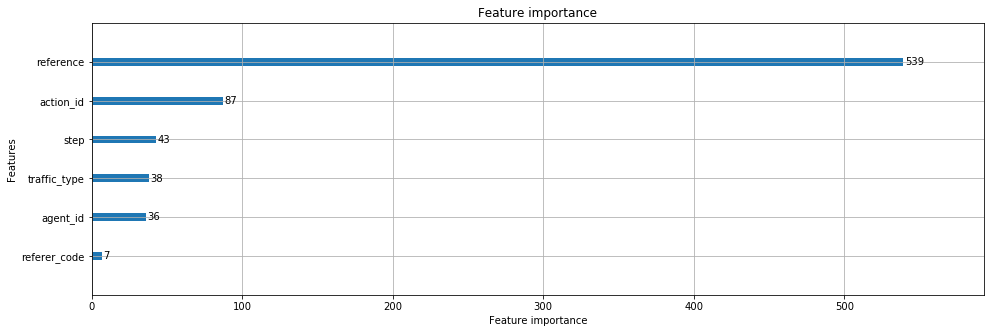

[0.3509415830337009, 0.875905380731093, 0.9721216995040879, 0.04754350889843007]


In [9]:
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

score_ll = metrics.log_loss(y_test, predict_y_proba_gbm)
score_ac = metrics.accuracy_score(y_test, predict_y_gbm)
score_pr = metrics.precision_score(y_test, predict_y_gbm)
score_re = metrics.recall_score(y_test, predict_y_gbm)
score = [score_ll, score_ac, score_pr, score_re]
    
ax = lightgbm.plot_importance(model, max_num_features=10, figsize=(16, 5))
plt.show()
    
gbmDF = pd.DataFrame([tuple(model.feature_importance())], columns= model.feature_name())
gbmDF.sort_index(axis=1, inplace=True)

print (score)
